In [1]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = 0

from importlib import import_module
from sklearn.model_selection import KFold
from monai.transforms import (
    Compose,
    ScaleIntensityd,
    EnsureTyped,
    EnsureChannelFirstd,
    Resized,
)
import numpy as np
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from sklearn.metrics import jaccard_score

# special imports
from datasets_utils.datasets import ABUS_dataset
sys.path.append(str(repo_path / 'SAMed')) if str(repo_path / 'SAMed') not in sys.path else None
from SAMed.segment_anything import sam_model_registry

# Inference of SAMed

## Setup

In [9]:
# HP
run_name = 'vanilla_1class'
fold_num = 0

# run path
weights_path = repo_path / f'experiments/SAMed_ABUS/results/{run_name}/fold{fold_num}/weights'
dirs = os.listdir(weights_path)
# dirs.sort() # sort by epoch
# last_epoch = dirs[-1] # get last epoch
# best_epoch = dirs[-2] # get best epoch

Model

In [37]:
# get SAM model
checkpoint_dir = repo_path / 'checkpoints'
sam, _ = sam_model_registry['vit_b'](image_size=256,
                                    num_classes=3,
                                    checkpoint=str(checkpoint_dir / 'sam_vit_b_01ec64.pth'),
                                    pixel_mean=[0, 0, 0],
                                    pixel_std=[1, 1, 1])
# load lora model
pkg = import_module('sam_lora_image_encoder')
model = pkg.LoRA_Sam(sam, 4)
# load weighs
# load_path = weights_path / best_epoch
load_path = repo_path / 'experiments/SAMed_ABUS/results/vanilla_3class/fold0/weights/epoch_73.pth'
model.load_lora_parameters(str(load_path))
model.eval()
model.to(device);

Data

In [38]:
# create fold
kf = KFold(n_splits=5,shuffle=True,random_state=0)
for fold_n, (_, val_ids) in enumerate(kf.split(range(100))):
    break
print(f'The number of patients in the validation set is {len(val_ids)}')
print(f'The patient ids in the validation set are {val_ids}')
# transform
val_transform = Compose(
        [
            EnsureChannelFirstd(keys=['label'], channel_dim='no_channel'),

            ScaleIntensityd(keys=["image"]),

            Resized(keys=["image", "label"], spatial_size=(256, 256),mode=['area','nearest']),
            EnsureTyped(keys=["image"])
        ])

The number of patients in the validation set is 20
The patient ids in the validation set are [ 2  7  8 13 16 22 24 26 30 33 53 54 55 73 75 78 86 92 93 95]


In [22]:
# HP
batch_size = 1
multimask_output = True

pat_num = -1
pat_id = [val_ids[pat_num]]

# get data
root_path = repo_path / 'data/challange_2023/with_lesion'
path_images = (root_path / "image_mha")
path_labels = (root_path / "label_mha")
# get all files in the folder in a list, only mha files
image_files = sorted([file for file in os.listdir(path_images) if file.endswith('.mha')])
# now,experiments/SAMed_ABUS/results/vanilla_1class/fold0/weights/epoch_99.pthfiles = np.array([path_images / i for i in val_files])
label_files = np.array([path_labels / i for i in val_files])
list_val = [image_files, label_files] # this is what we will pass to the dataset <-

# define dataset and dataloader
db_val = ABUS_dataset(transform=val_transform,list_dir=list_val)   
valloader = DataLoader(db_val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
print(f'The number of slices is {len(db_val)}')

The number of slices is 24


/home/ricardo/ABUS2023_documents/tdsc_abus23/datasets_utils/datasets.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


## Evaluate

Jaccard score for slice 0 is 0.0
Jaccard score for slice 1 is 0.0
Jaccard score for slice 2 is 0.0
Jaccard score for slice 3 is 0.0
Jaccard score for slice 4 is 0.0
Jaccard score for slice 5 is 0.0
Jaccard score for slice 6 is 0.37383177570093457
Jaccard score for slice 7 is 0.3794642857142857
Jaccard score for slice 8 is 0.3682170542635659
Jaccard score for slice 9 is 0.3022222222222222
Jaccard score for slice 10 is 0.6267123287671232
Jaccard score for slice 11 is 0.664576802507837
Jaccard score for slice 12 is 0.6234567901234568
Jaccard score for slice 13 is 0.6757575757575758
Jaccard score for slice 14 is 0.688953488372093
Jaccard score for slice 15 is 0.7032640949554896
Jaccard score for slice 16 is 0.6891025641025641
Jaccard score for slice 17 is 0.6020761245674741
Jaccard score for slice 18 is 0.711864406779661
Jaccard score for slice 19 is 0.6
Jaccard score for slice 20 is 0.1271186440677966
Jaccard score for slice 21 is 0.15089514066496162


/tmp/ipykernel_1187786/3724685155.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))


Jaccard score for slice 22 is 0.0
Jaccard score for slice 23 is 0.0
Jaccard score for patient [95] is 0.4832009773976787


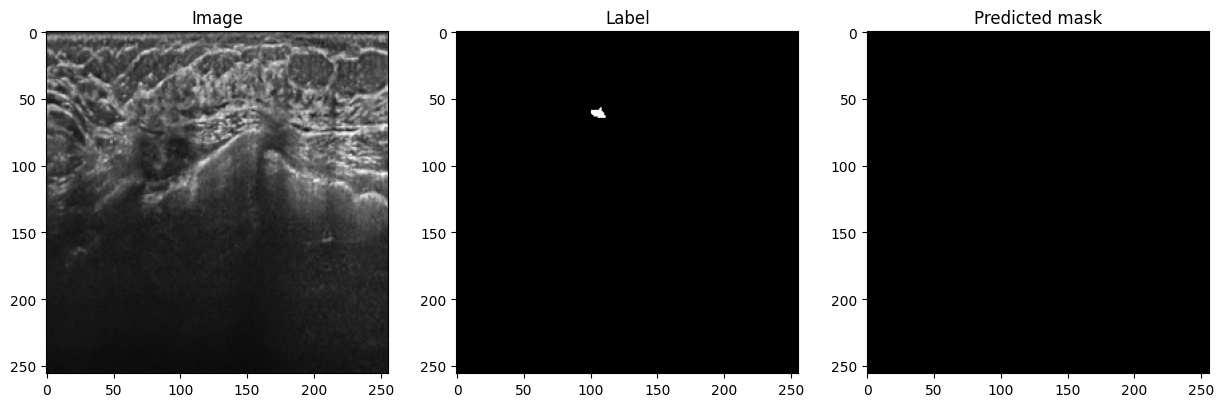

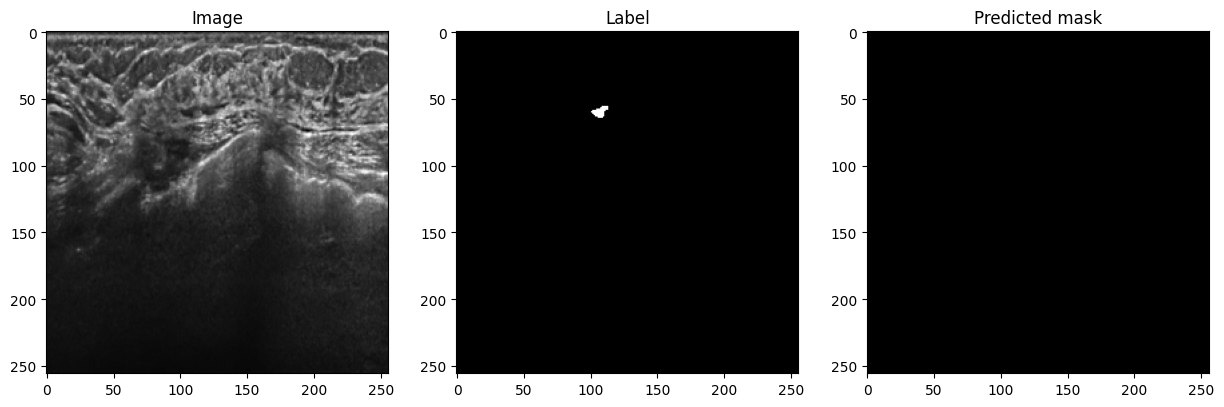

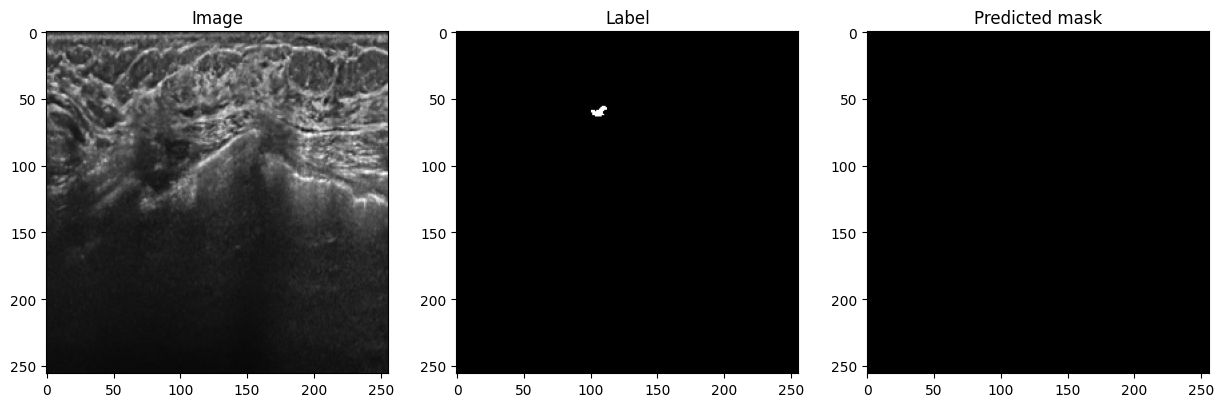

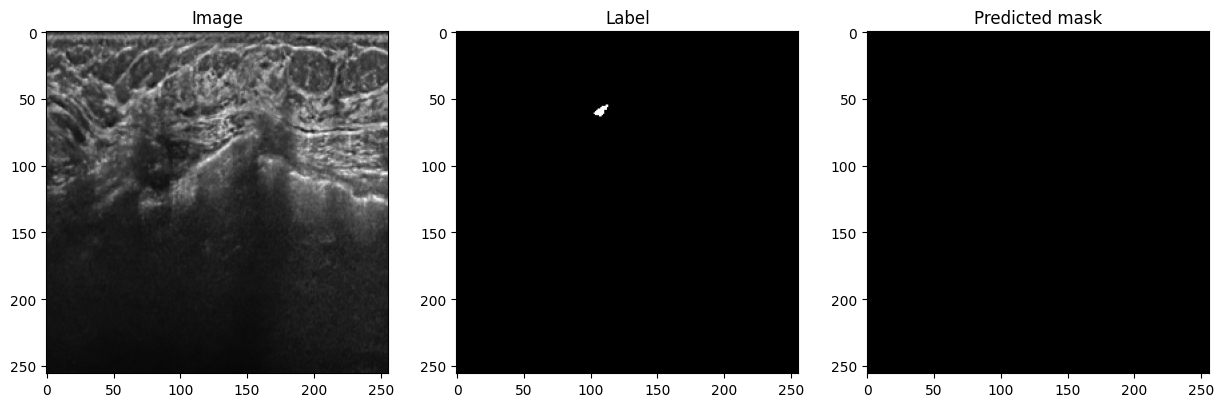

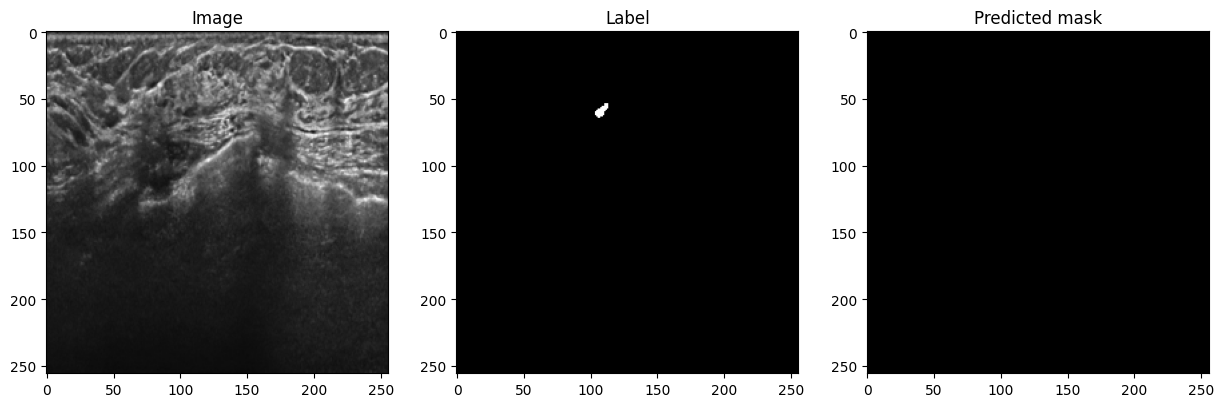

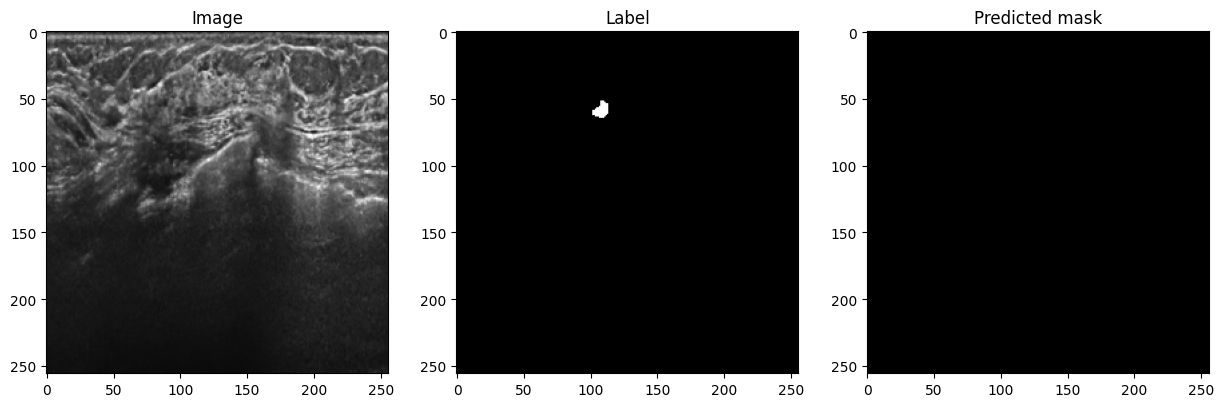

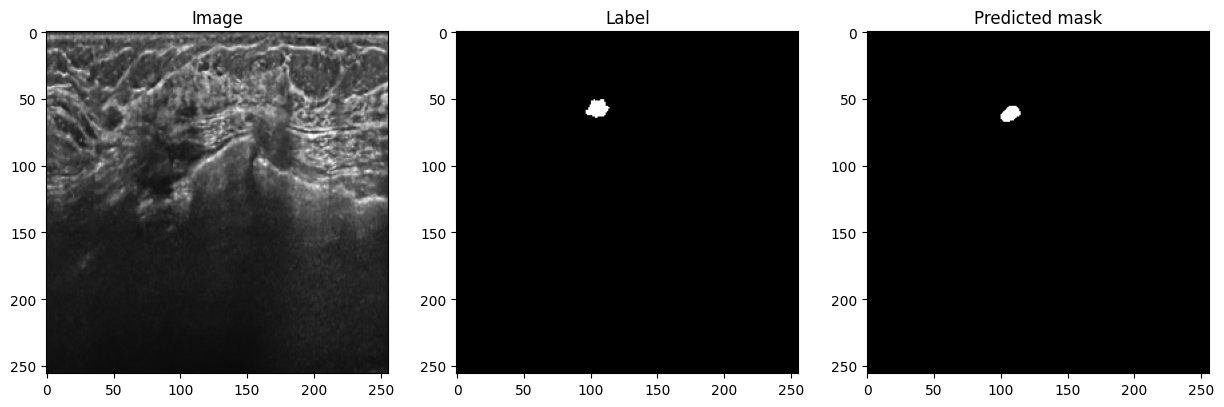

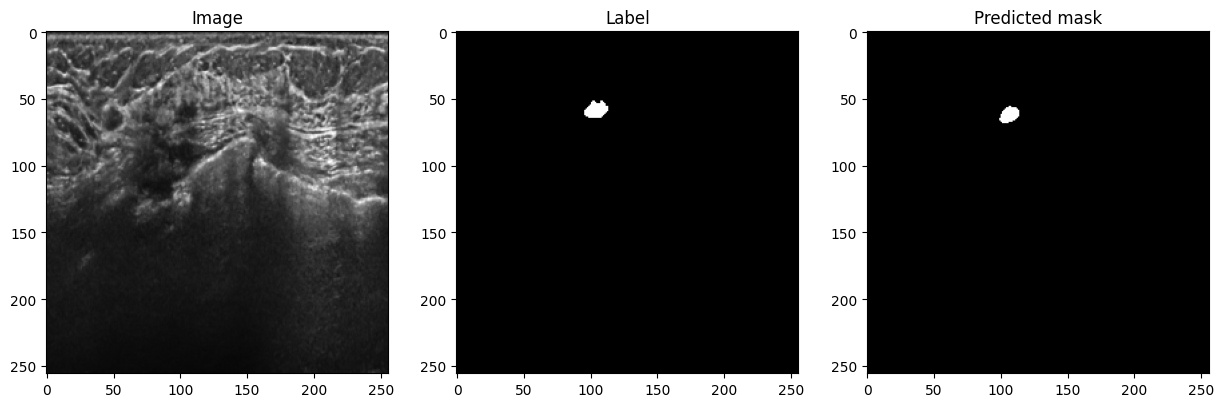

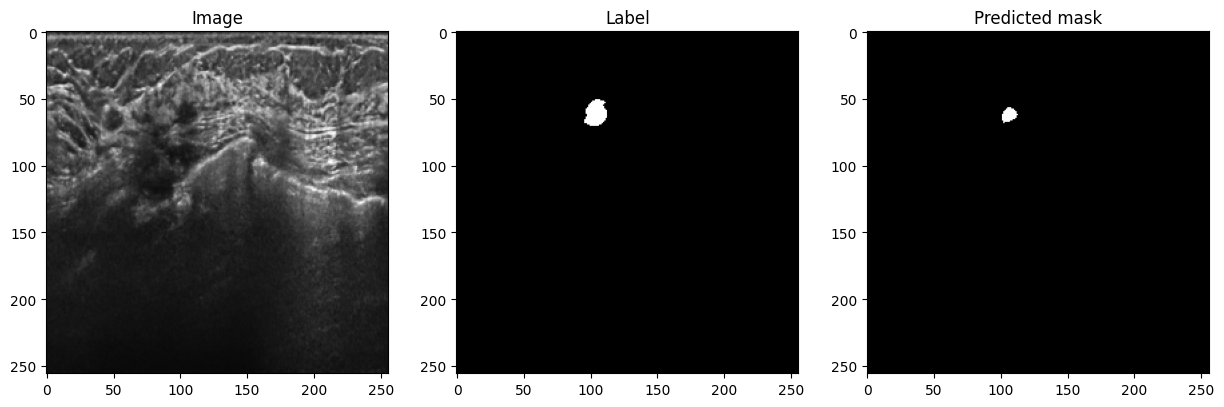

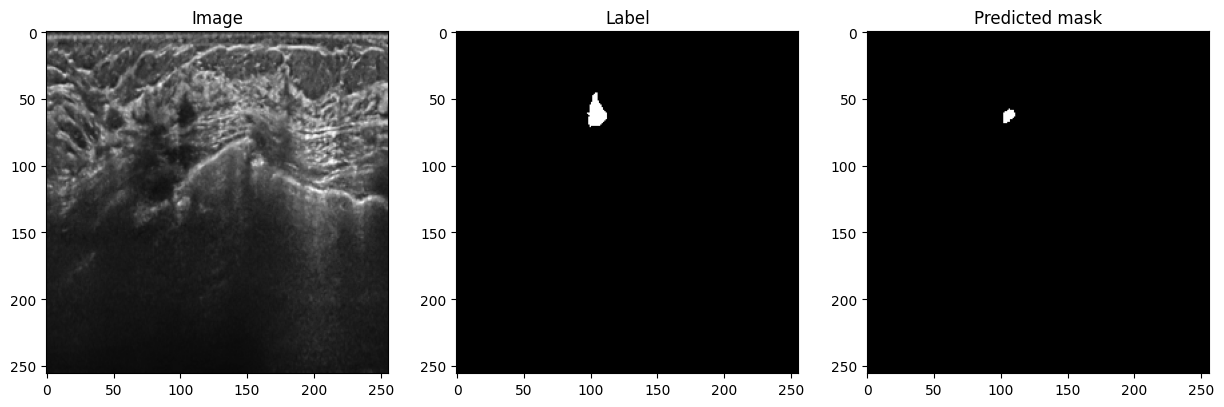

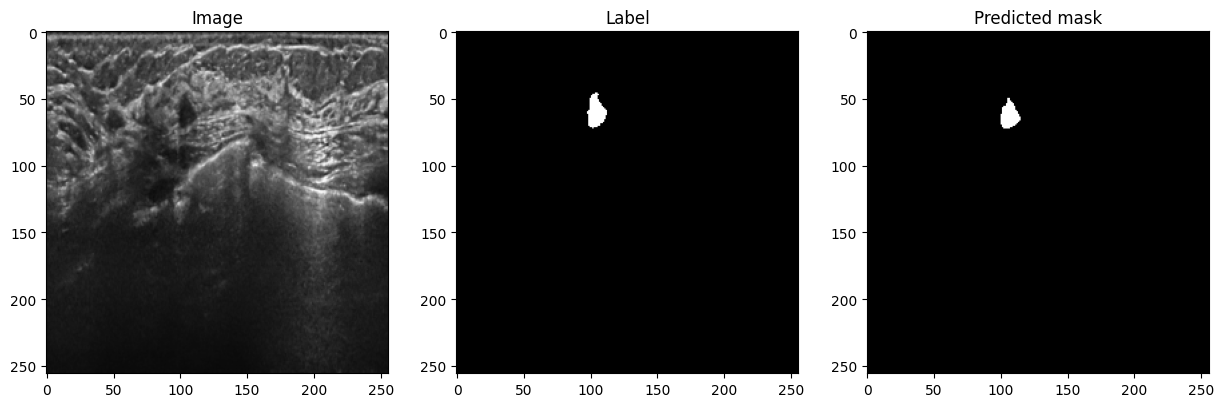

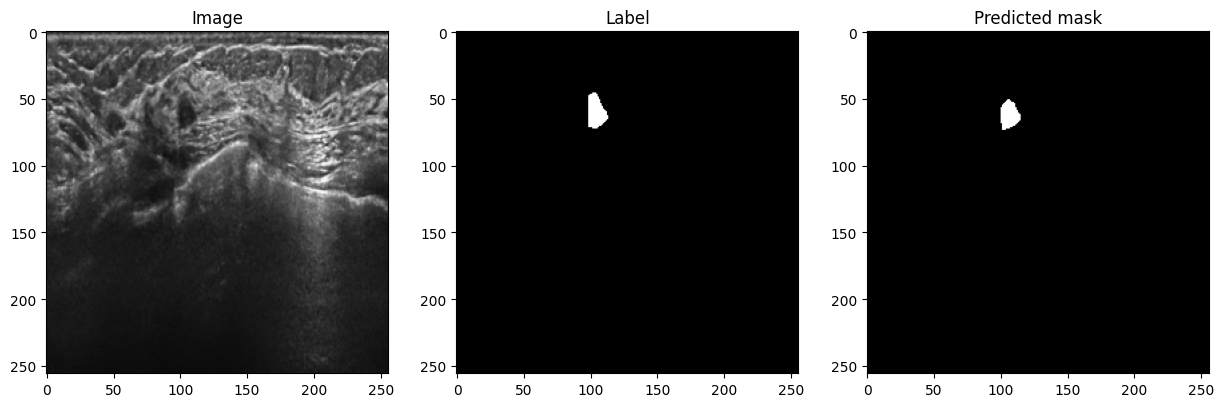

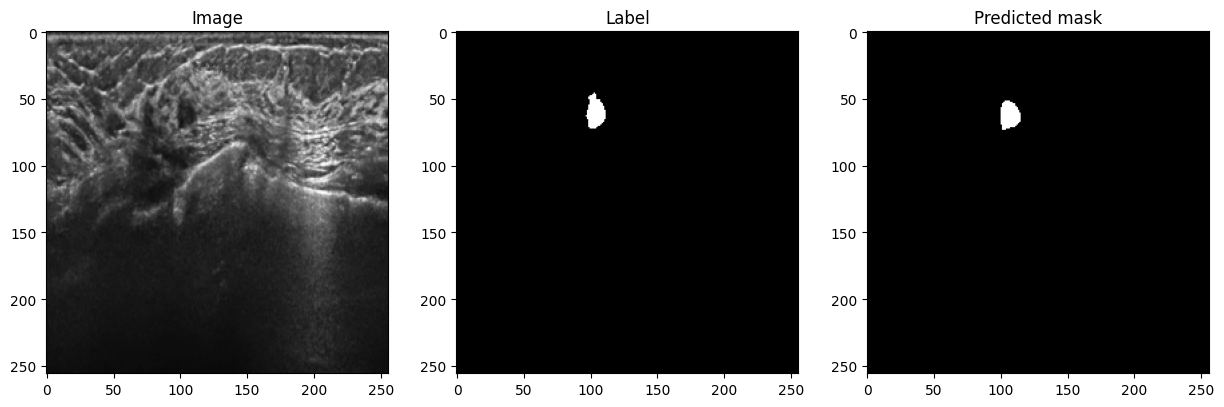

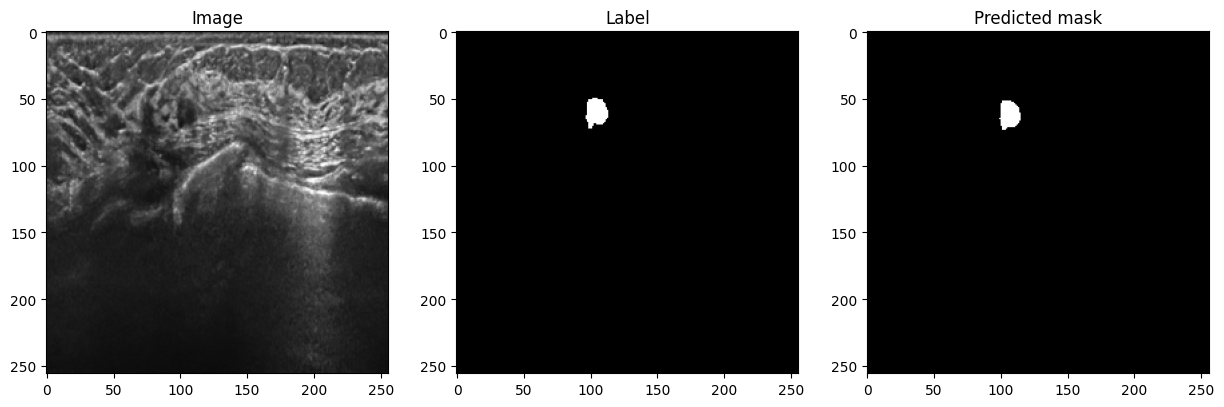

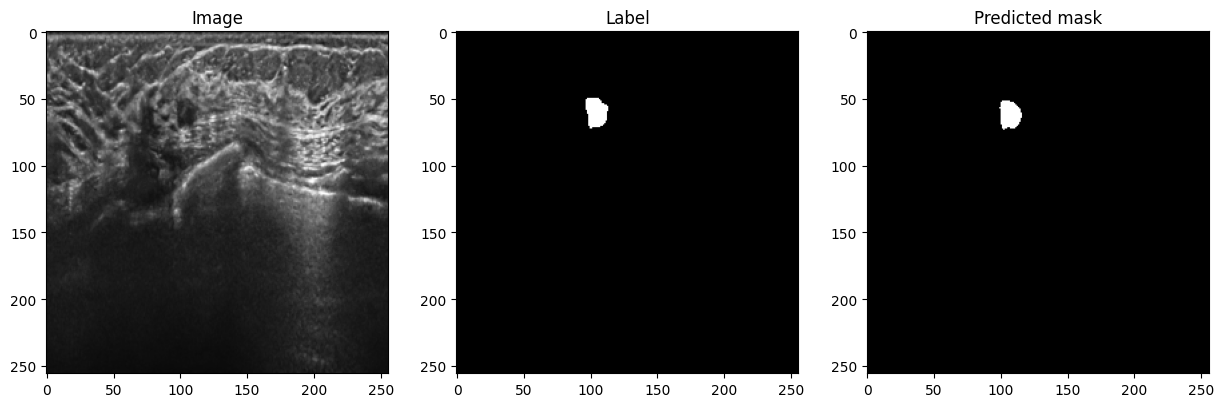

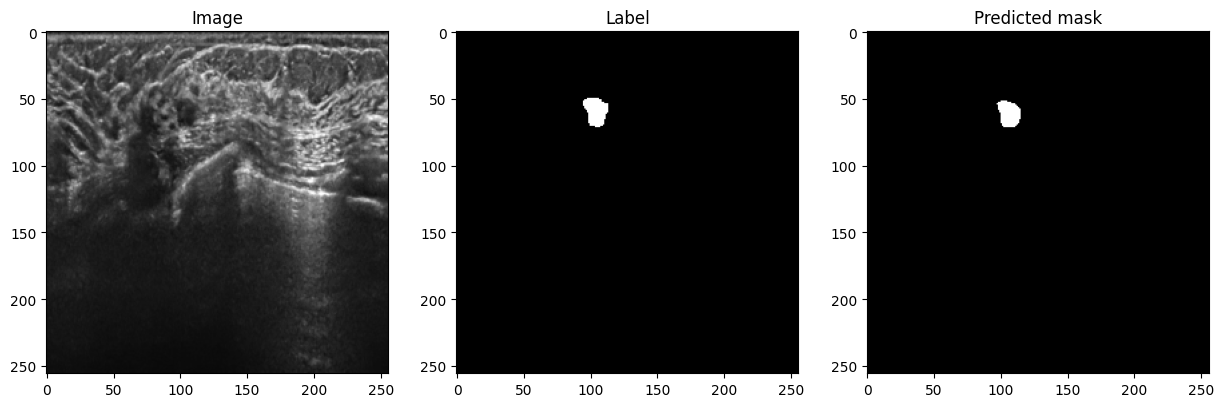

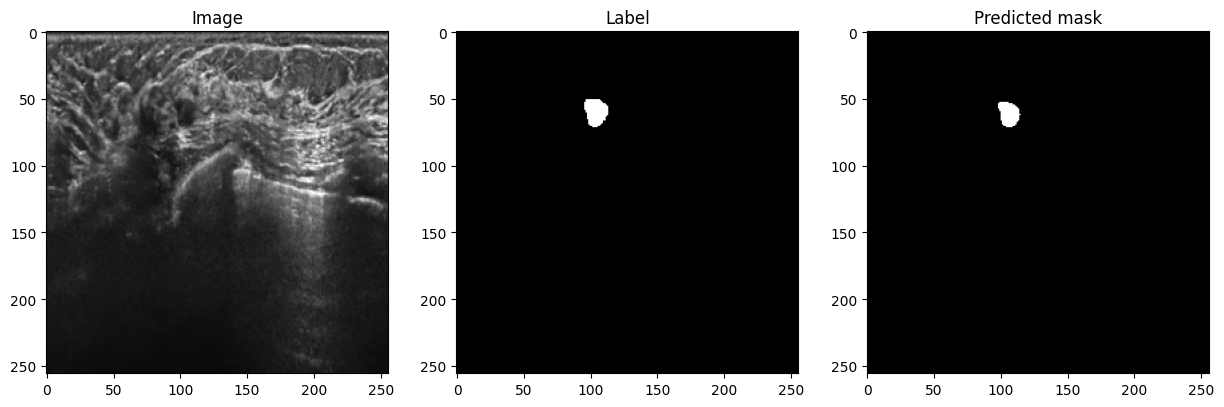

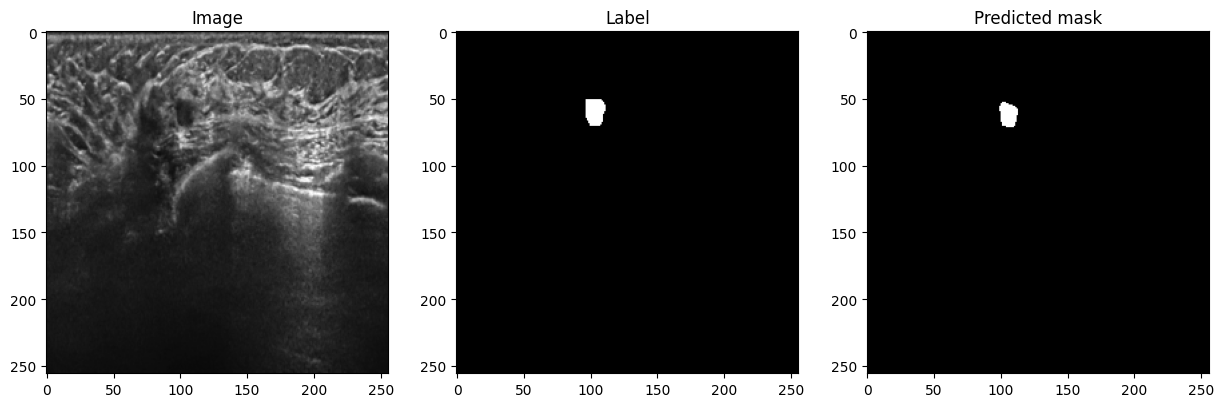

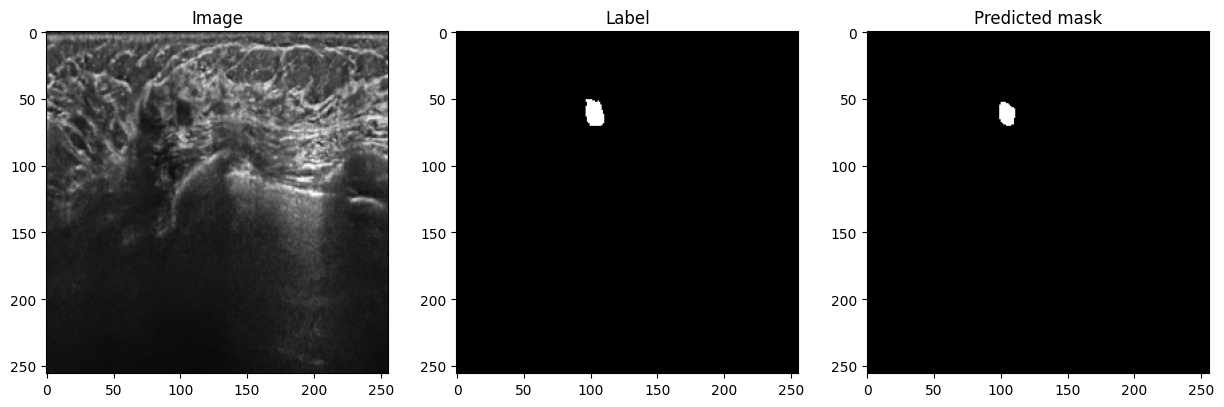

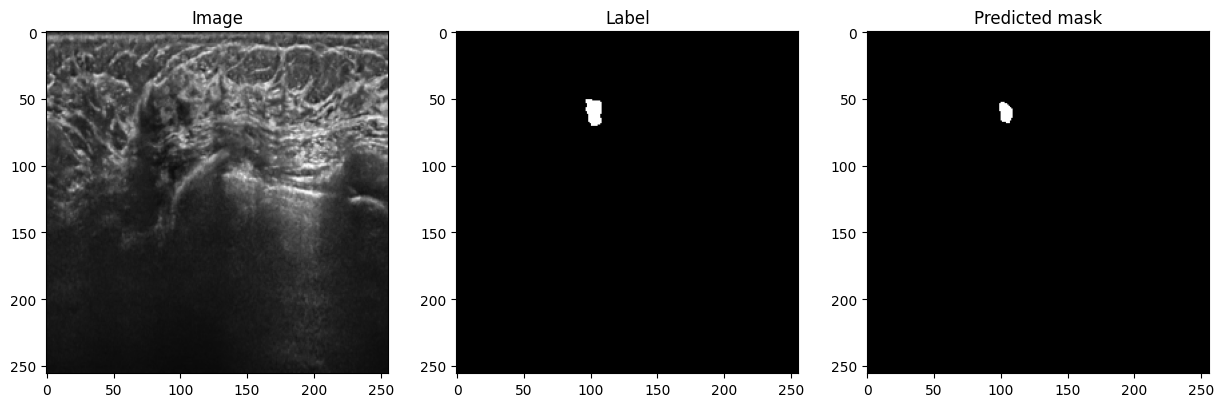

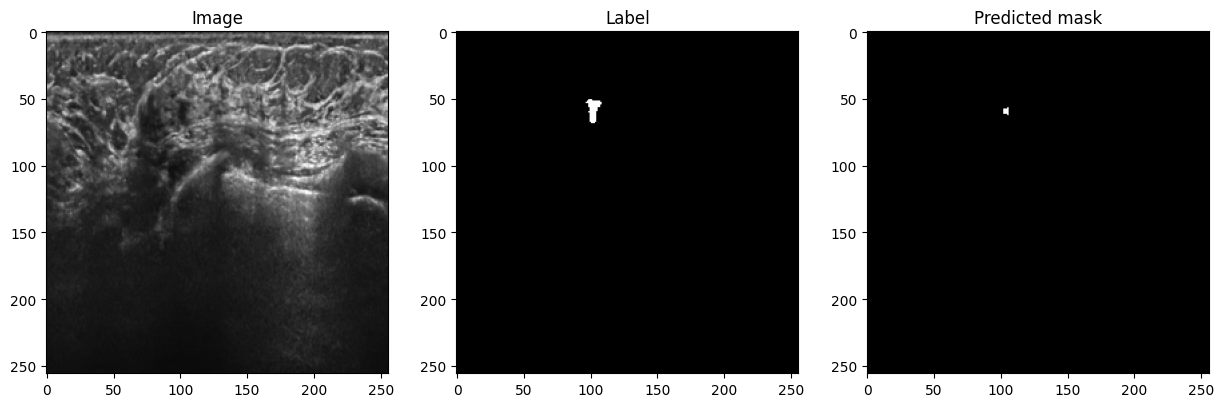

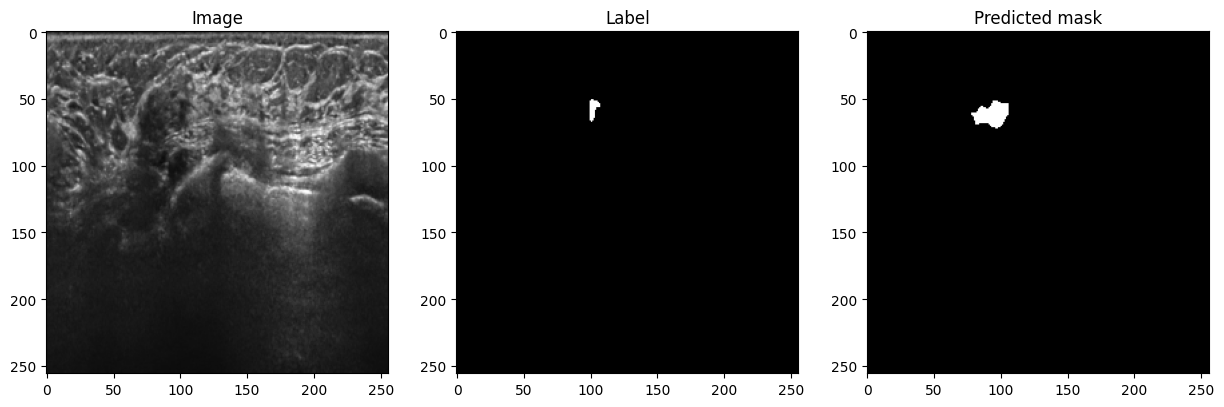

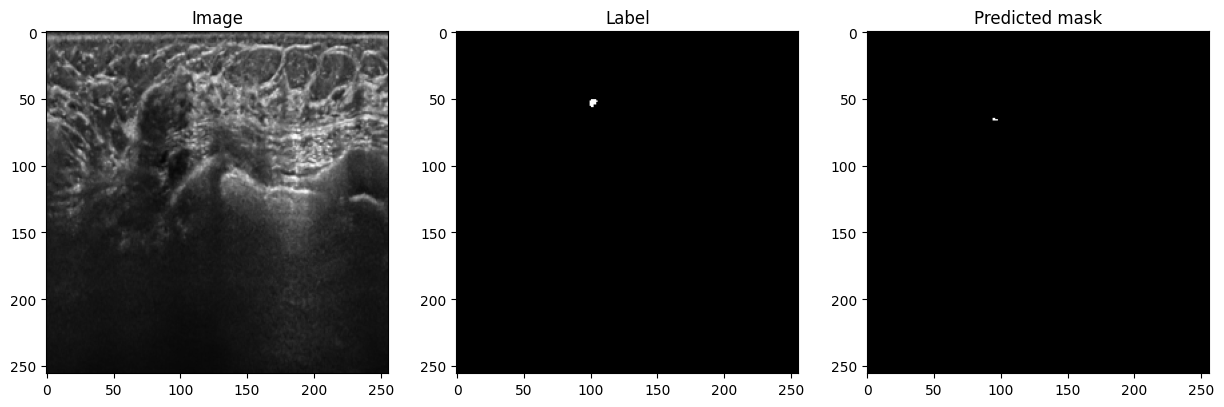

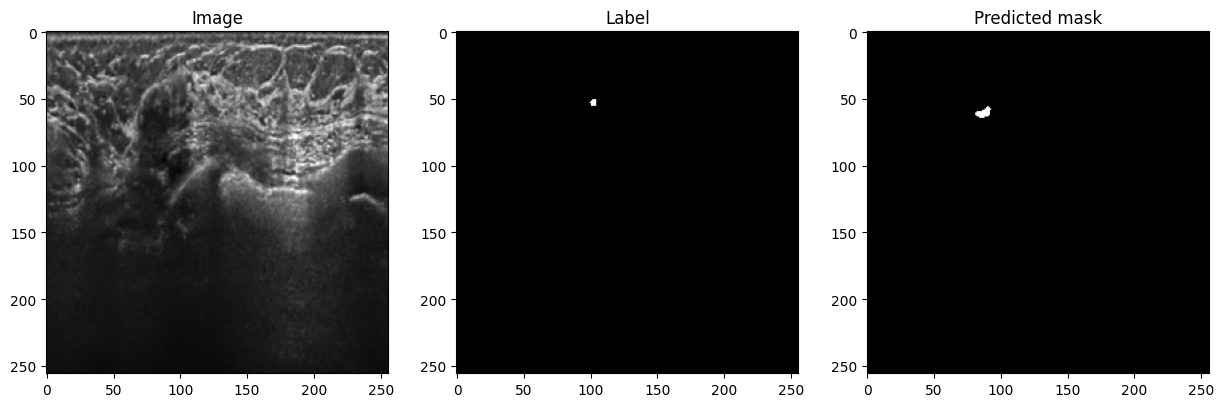

In [14]:
labels_array = np.zeros((len(db_val), 256, 256))
preds_array = np.zeros((len(db_val), 256, 256))
for batch_num, sample_batch in enumerate(valloader):
    # get data
    image_batch, label_batch = sample_batch["image"].to(device), sample_batch["label"].to(device)
    # forward and losses computing
    outputs = model(image_batch, multimask_output, 256)
    output_masks = outputs['masks'].detach().cpu()
    output_masks = torch.argmax(torch.softmax(output_masks, dim=1), dim=1, keepdim=True)

    #label_batch and output_masks in array
    image_batch = image_batch[0, 0, :, :].cpu().numpy()
    label_batch = label_batch[0, :, :].cpu().numpy()
    output_masks = output_masks[0, 0, :, :].numpy()
    # save in array
    labels_array[batch_num, :, :] = label_batch
    preds_array[batch_num, :, :] = output_masks
    # slide jaccard score
    jaccard_value = jaccard_score(label_batch.flatten(), output_masks.flatten())
    
    print(f'Jaccard score for slice {batch_num} is {jaccard_value}')
    # show image, label and predicted mask
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image_batch, cmap='gray')
    axs[0].set_title('Image')
    axs[1].imshow(label_batch, cmap='gray')
    axs[1].set_title('Label')
    axs[2].imshow(output_masks, cmap='gray')
    axs[2].set_title('Predicted mask')
# get 3D jaccard score
jaccard_value = jaccard_score(labels_array.flatten(), preds_array.flatten())
print(f'Jaccard score for patient {pat_id} is {jaccard_value}')

In [15]:
# analyze output
pure_output = outputs['low_res_logits'].detach().cpu()
pure_mask = outputs['masks'].detach().cpu()

Low resolution logits shape: torch.Size([1, 2, 64, 64])
Masks shape: torch.Size([1, 2, 256, 256])


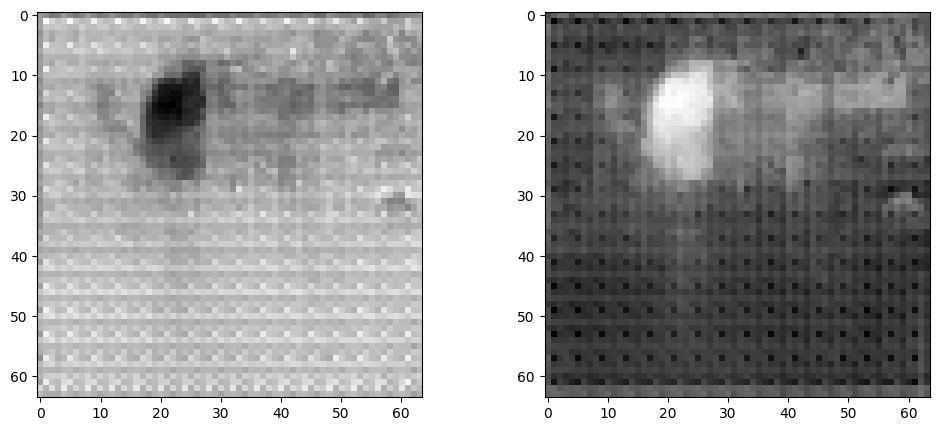

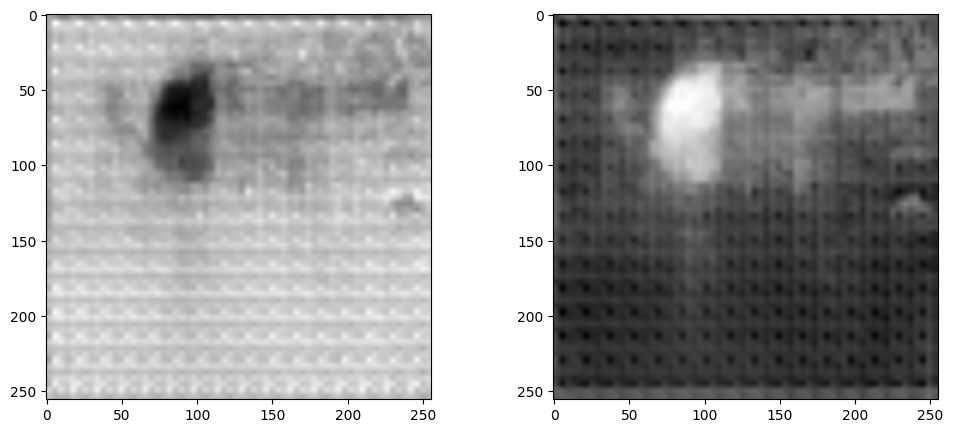

In [16]:
print(f'Low resolution logits shape: {pure_output.shape}')
fig, axs = plt.subplots(1, pure_output.shape[1], figsize=(12, 5))
for i in range(pure_output.shape[1]):
    axs[i].imshow(pure_output[0, i, :, :].numpy(), cmap='gray')
print(f'Masks shape: {pure_mask.shape}')
fig, axs = plt.subplots(1, pure_mask.shape[1], figsize=(12, 5))
for i in range(pure_mask.shape[1]):
    axs[i].imshow(pure_mask[0, i, :, :].numpy(), cmap='gray')

logits after softmax shape: torch.Size([1, 2, 64, 64])


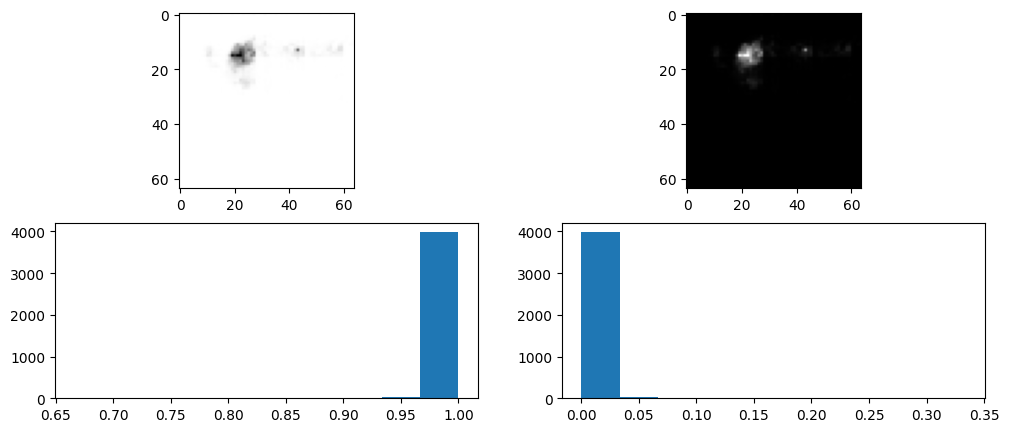

In [40]:
inputs = torch.softmax(pure_output, dim=1)
print(f'logits after softmax shape: {inputs.shape}')
fig, axs = plt.subplots(2, pure_output.shape[1], figsize=(12, 5))
for i in range(pure_output.shape[1]):
    axs[0,i].imshow(inputs[0, i, :, :].numpy(), cmap='gray')
    # histogram per image
    axs[1,i].hist(inputs[0, i, :, :].numpy().flatten())

## Full evaluation

In [39]:
# HP
batch_size = 1
multimask_output = True

patients_jaccard = np.zeros((len(val_ids), 2))
patients_dice = np.zeros((len(val_ids), 2))
for pat_num in range(len(val_ids)):
    pat_id = [val_ids[pat_num]]

    # get data
    root_path = repo_path / 'data/challange_2023/with_lesion'
    path_images = (root_path / "image_mha")
    path_labels = (root_path / "label_mha")
    # get all files in the folder in a list, only mha files
    image_files = sorted([file for file in os.listdir(path_images) if file.endswith('.mha')])
    # now, we will check if the path has at least one of the ids in the train_ids list
    val_files = [file for file in image_files if any(f'id_{id}_' in file for id in pat_id)]
    # create final paths
    image_files = np.array([path_images / i for i in val_files])
    label_files = np.array([path_labels / i for i in val_files])
    list_val = [image_files, label_files] # this is what we will pass to the dataset <-

    # define dataset and dataloader
    db_val = ABUS_dataset(transform=val_transform,list_dir=list_val)   
    valloader = DataLoader(db_val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
    print(f'The number of slices is {len(db_val)}')

    labels_array = np.zeros((len(db_val), 256, 256))
    preds_array = np.zeros((len(db_val), 256, 256))
    for batch_num, sample_batch in enumerate(valloader):
        # get data
        image_batch, label_batch = sample_batch["image"].to(device), sample_batch["label"].to(device)
        # forward and losses computing
        outputs = model(image_batch, multimask_output, 256)
        output_masks = outputs['masks'].detach().cpu()
        output_masks = torch.argmax(torch.softmax(output_masks, dim=1), dim=1, keepdim=True)

        #label_batch and output_masks in array
        image_batch = image_batch[0, 0, :, :].cpu().numpy()
        label_batch = label_batch[0, :, :].cpu().numpy()
        output_masks = output_masks[0, 0, :, :].numpy()
        # save in array
        labels_array[batch_num, :, :] = label_batch
        preds_array[batch_num, :, :] = output_masks
        
        # slice jaccard score
        # jaccard_slice = jaccard_score(label_batch.flatten(), output_masks.flatten())
        # print(f'Jaccard score for slice {batch_num} is {jaccard_slice}')
        # # show image, label and predicted mask
        # fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        # axs[0].imshow(image_batch, cmap='gray')
        # axs[0].set_title('Image')
        # axs[1].imshow(label_batch, cmap='gray')
        # axs[1].set_title('Label')
        # axs[2].imshow(output_masks, cmap='gray')
        # axs[2].set_title('Predicted mask')
    # get 3D jaccard score
    jaccard_value = jaccard_score(labels_array.flatten(), preds_array.flatten())
    # dice from jaccard
    dice_value = 2*jaccard_value/(1+jaccard_value)
    print(f'Jaccard score for patient {pat_id} is {jaccard_value}')
    print(f'Dice score for patient {pat_id} is {dice_value}')
    # store in array
    patients_jaccard[pat_num, 0] = pat_id[0]
    patients_jaccard[pat_num, 1] = jaccard_value
    patients_dice[pat_num, 0] = pat_id[0]
    patients_dice[pat_num, 1] = dice_value

The number of slices is 48


/home/ricardo/ABUS2023_documents/tdsc_abus23/datasets_utils/datasets.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [2] is 0.7031411448646414
Dice score for patient [2] is 0.8256992052417642
The number of slices is 14


/home/ricardo/ABUS2023_documents/tdsc_abus23/datasets_utils/datasets.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [7] is 0.6181818181818182
Dice score for patient [7] is 0.7640449438202247
The number of slices is 33


/home/ricardo/ABUS2023_documents/tdsc_abus23/datasets_utils/datasets.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [8] is 0.4720700985761227
Dice score for patient [8] is 0.6413690476190476
The number of slices is 14


/home/ricardo/ABUS2023_documents/tdsc_abus23/datasets_utils/datasets.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [13] is 0.3416998265483114
Dice score for patient [13] is 0.5093536121673004
The number of slices is 39


/home/ricardo/ABUS2023_documents/tdsc_abus23/datasets_utils/datasets.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [16] is 0.15077571923482452
Dice score for patient [16] is 0.26204188481675394
The number of slices is 55


/home/ricardo/ABUS2023_documents/tdsc_abus23/datasets_utils/datasets.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [22] is 0.5957059388506483
Dice score for patient [22] is 0.7466362370998282
The number of slices is 22


/home/ricardo/ABUS2023_documents/tdsc_abus23/datasets_utils/datasets.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [24] is 0.6515527950310559
Dice score for patient [24] is 0.7890184279804439
The number of slices is 35


/home/ricardo/ABUS2023_documents/tdsc_abus23/datasets_utils/datasets.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [26] is 0.5318762609280431
Dice score for patient [26] is 0.6944115193818868
The number of slices is 13


/home/ricardo/ABUS2023_documents/tdsc_abus23/datasets_utils/datasets.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [30] is 0.0
Dice score for patient [30] is 0.0
The number of slices is 41


/home/ricardo/ABUS2023_documents/tdsc_abus23/datasets_utils/datasets.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [33] is 0.7654356409941113
Dice score for patient [33] is 0.8671351401550916
The number of slices is 16


/home/ricardo/ABUS2023_documents/tdsc_abus23/datasets_utils/datasets.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [53] is 0.13112480739599383
Dice score for patient [53] is 0.23184852199972755
The number of slices is 21


/home/ricardo/ABUS2023_documents/tdsc_abus23/datasets_utils/datasets.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [54] is 0.29440774169535683
Dice score for patient [54] is 0.45489181223492203
The number of slices is 56


/home/ricardo/ABUS2023_documents/tdsc_abus23/datasets_utils/datasets.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [55] is 0.5333239973715677
Dice score for patient [55] is 0.6956442321202754
The number of slices is 19


/home/ricardo/ABUS2023_documents/tdsc_abus23/datasets_utils/datasets.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [73] is 0.17202956225127913
Dice score for patient [73] is 0.293558401241754
The number of slices is 63


/home/ricardo/ABUS2023_documents/tdsc_abus23/datasets_utils/datasets.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [75] is 0.8395774169275954
Dice score for patient [75] is 0.9127937853573255
The number of slices is 9


/home/ricardo/ABUS2023_documents/tdsc_abus23/datasets_utils/datasets.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [78] is 0.0
Dice score for patient [78] is 0.0
The number of slices is 21


/home/ricardo/ABUS2023_documents/tdsc_abus23/datasets_utils/datasets.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [86] is 0.5132039452752147
Dice score for patient [86] is 0.678301093355761
The number of slices is 15


/home/ricardo/ABUS2023_documents/tdsc_abus23/datasets_utils/datasets.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [92] is 0.5118005046756716
Dice score for patient [92] is 0.6770741286205204
The number of slices is 44


/home/ricardo/ABUS2023_documents/tdsc_abus23/datasets_utils/datasets.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [93] is 0.703050388425629
Dice score for patient [93] is 0.8256366261429976
The number of slices is 24


/home/ricardo/ABUS2023_documents/tdsc_abus23/datasets_utils/datasets.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [95] is 0.5851612903225807
Dice score for patient [95] is 0.7382987382987384


In [40]:
print(f'The jaccard score: \n{patients_jaccard}')
print(f'The dice score: \n{patients_dice}')
print(f'mean dice score: {np.mean(patients_dice[:, 1])}')

The jaccard score: 
[[ 2.          0.70314114]
 [ 7.          0.61818182]
 [ 8.          0.4720701 ]
 [13.          0.34169983]
 [16.          0.15077572]
 [22.          0.59570594]
 [24.          0.6515528 ]
 [26.          0.53187626]
 [30.          0.        ]
 [33.          0.76543564]
 [53.          0.13112481]
 [54.          0.29440774]
 [55.          0.533324  ]
 [73.          0.17202956]
 [75.          0.83957742]
 [78.          0.        ]
 [86.          0.51320395]
 [92.          0.5118005 ]
 [93.          0.70305039]
 [95.          0.58516129]]
The dice score: 
[[ 2.          0.82569921]
 [ 7.          0.76404494]
 [ 8.          0.64136905]
 [13.          0.50935361]
 [16.          0.26204188]
 [22.          0.74663624]
 [24.          0.78901843]
 [26.          0.69441152]
 [30.          0.        ]
 [33.          0.86713514]
 [53.          0.23184852]
 [54.          0.45489181]
 [55.          0.69564423]
 [73.          0.2935584 ]
 [75.          0.91279379]
 [78.          0.